In [1]:
%load_ext autoreload
%autoreload 2

### data loading and preparation

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

/home/ec2-user/miniforge3/envs/concord/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
proj_name = "cel_packerN2_hyperv2"
file_name = "cel_packerN2_hyperv2"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad')
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000, subset=False)
sc.tl.pca(adata, n_comps=300, svd_solver='arpack', use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
adata = sc.read_h5ad(data_dir / DATA_FILE)

### Create jobs

In [5]:
import json, math, subprocess, scanpy as sc
from pathlib import Path

# ------------------------------------------------------------
# 1. global sweep settings
# ------------------------------------------------------------
TOTAL_STEPS   = 10000          # keep *updates* per run constant
BASE_LR       = 1e-2            # lr used at BASE_BATCH
BASE_BATCH    = 256              # reference batch for LR scaling


N_CELLS = adata.n_obs
print(f"✔ Dataset has {N_CELLS:,} cells")


✔ Dataset has 94,276 cells


In [13]:
# HCL mode jobs
# ------------------------------------------------------------
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
# ------------------------------------------------------------
hcl_base_args = {
    "latent_dim": 300,
    "batch_size": BASE_BATCH,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.0,
    "clr_beta": 1.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}

param_grid = {
    "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    "clr_beta" : [0.0, 0.5, 1.0, 2.0, 6.0],  # sweep 5 values
    "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 5 values
    "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    "n_epochs": [1, 2, 3, 4, 5, 10, 15, 20, 30]
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
hcl_jobs = ccd.bm.expand_one_at_a_time(
    hcl_base_args,
    param_grid,
    base_tag="concord_hcl",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in hcl_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE.name,
        "--methods",        "concord_hcl",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "cellpath",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(hcl_jobs)} jobs for concord_hcl mode in {output_dir}")

✔ 16 batch size: 2 epochs, 5893 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-16.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-16.sh

✔ 32 batch size: 4 epochs, 2947 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-32.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-32.sh

✔ 64 batch size: 7 epochs, 1474 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-64.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_size-64.sh

✔ 128 batch size: 14 epochs, 737 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_hcl_concord_hcl_batch_siz

In [15]:
# KNN mode jobs
# ------------------------------------------------------------
# 2. base & grid
# ------------------------------------------------------------
knn_base_args = {
    "latent_dim": 300,
    "batch_size": BASE_BATCH,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.3,
    "clr_beta": 0.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}


param_grid = {
    "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    "p_intra_knn" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    "sampler_knn": [100, 300, 1000, 3000, 10000],  # sweep 5 values
    "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
    "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    "n_epochs": [1,2,3,4,5, 10, 15, 20, 30]
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
knn_jobs = ccd.bm.expand_one_at_a_time(
    knn_base_args,
    param_grid,
    base_tag="concord_knn",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in knn_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # b) scale learning-rate linearly with batch size
    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE.name,
        "--methods",        "concord_knn",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "cellpath",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(knn_jobs)} jobs for concord_knn mode in {output_dir}")

✔ 16 batch size: 2 epochs, 5893 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-16.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-16.sh

✔ 32 batch size: 4 epochs, 2947 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-32.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-32.sh

✔ 64 batch size: 7 epochs, 1474 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-64.py
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_size-64.sh

✔ 128 batch size: 14 epochs, 737 steps per epoch
✅ Generated: benchmark_cel_packerN2_hyperv2/benchmark_cel_packerN2_hyperv2_concord_knn_concord_knn_batch_siz

In [16]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_cel_packerN2_hyperv2/submit_all_cel_packerN2_hyperv2.sh” to queue every job.


In [17]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = """#!/bin/bash
set -euo pipefail
cd "$(dirname "$0")"           # work inside this folder
shopt -s nullglob              # empty globs expand to nothing

for job in *.py; do
  base=${job%.py}              # strip the .py suffix
  log="${base}.log"            # e.g. train_model.py → train_model.log

  echo ">>> $job   $(date)" | tee -a "$log"
  if python "$job" >>"$log" 2>&1; then
      echo ">>> finished OK"   | tee -a "$log"
  else
      echo ">>> FAILED"        | tee -a "$log"
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_cel_packerN2_hyperv2/submit_sequential_cel_packerN2_hyperv2.sh” to queue jobs sequentially.


### Collect results

In [11]:
# Delete existing latents in adata.obsm
for key in list(adata.obsm.keys()):
    del adata.obsm[key]

In [6]:
adata.shape

(94276, 10000)

In [7]:
# hcl_keys = [kw['output_key'] for kw in hcl_jobs]
# knn_keys = []
# methods = hcl_keys + knn_keys
# print(f"total methods: {len(methods)}")

# Auto detect runned methods in the save_dir
import re
from typing import List, Optional
_RUN_DIR_RE = re.compile(r'^(concord_(?:hcl|knn)_.+?)_\d{4}-\d{4}$')

def discover_methods(save_root: Path) -> List[str]:
    """
    Scan `save_root` for run folders and return a sorted list of
    unique method prefixes (without the timestamp).
    """
    methods = {
        m.group(1)
        for p in save_root.iterdir()
        if p.is_dir() and (m := _RUN_DIR_RE.match(p.name))
    }
    return sorted(methods)

In [8]:
methods = discover_methods(save_dir)
methods

['concord_hcl_augmentation_mask_prob-0.1',
 'concord_hcl_augmentation_mask_prob-0.2',
 'concord_hcl_augmentation_mask_prob-0.3',
 'concord_hcl_augmentation_mask_prob-0.4',
 'concord_hcl_augmentation_mask_prob-0.5',
 'concord_hcl_augmentation_mask_prob-0.6',
 'concord_hcl_augmentation_mask_prob-0.7',
 'concord_hcl_augmentation_mask_prob-0.8',
 'concord_hcl_batch_size-1024',
 'concord_hcl_batch_size-128',
 'concord_hcl_batch_size-16',
 'concord_hcl_batch_size-2048',
 'concord_hcl_batch_size-256',
 'concord_hcl_batch_size-32',
 'concord_hcl_batch_size-512',
 'concord_hcl_batch_size-64',
 'concord_hcl_clr_beta-0.0',
 'concord_hcl_clr_beta-0.5',
 'concord_hcl_clr_beta-1.0',
 'concord_hcl_clr_beta-2.0',
 'concord_hcl_clr_beta-6.0',
 'concord_hcl_clr_temperature-0.1',
 'concord_hcl_clr_temperature-0.2',
 'concord_hcl_clr_temperature-0.3',
 'concord_hcl_clr_temperature-0.4',
 'concord_hcl_clr_temperature-0.5',
 'concord_hcl_clr_temperature-0.6',
 'concord_hcl_clr_temperature-0.7',
 'concord_hc

In [9]:
#methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive", "seurat_cca", "seurat_rpca"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
#adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad') # Load the log normalized but unfiltered adata
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)
methods = [m for m in methods if m in adata.obsm.keys()]

✅ obsm['concord_hcl_augmentation_mask_prob-0.1'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.2'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.3'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.4'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.5'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.6'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.7'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.8'] loaded
✅ obsm['concord_hcl_batch_size-1024'] loaded
✅ obsm['concord_hcl_batch_size-128'] loaded
✅ obsm['concord_hcl_batch_size-16'] loaded
✅ obsm['concord_hcl_batch_size-2048'] loaded
✅ obsm['concord_hcl_batch_size-256'] loaded
✅ obsm['concord_hcl_batch_size-32'] loaded
✅ obsm['concord_hcl_batch_size-512'] loaded
✅ obsm['concord_hcl_batch_size-64'] loaded
✅ obsm['concord_hcl_clr_beta-0.0'] loaded
✅ obsm['concord_hcl_clr_beta-0.5'] loaded
✅ obsm['concord_hcl_clr_beta-1.0'] loaded
✅ obsm['concord_hcl_clr_beta-2.0'] loaded
✅ obsm['concord_hcl_clr_beta-6.0'

In [10]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype(str)  # Ensure all values are strings
adata.obs['cell_type'][adata.obs['cell_type'].isin(['', 'nan', 'NaN', 'NA', 'na', 'unannotated'])] = 'NaN'

In [24]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='cel')
print(f"Saved viscello to {data_dir / f'cello_{proj_name}_{file_suffix}'}")

VisCello project created at ../data/cel_packerN2/cello_cel_packerN2_Jun28-1251
Saved viscello to ../data/cel_packerN2/cello_cel_packerN2_Jun28-1251


### Benchmarking

✅ Benchmark summary saved to: ../save/cel_packerN2_hyperv2/benchmark_summary_Jul04-0327.tsv


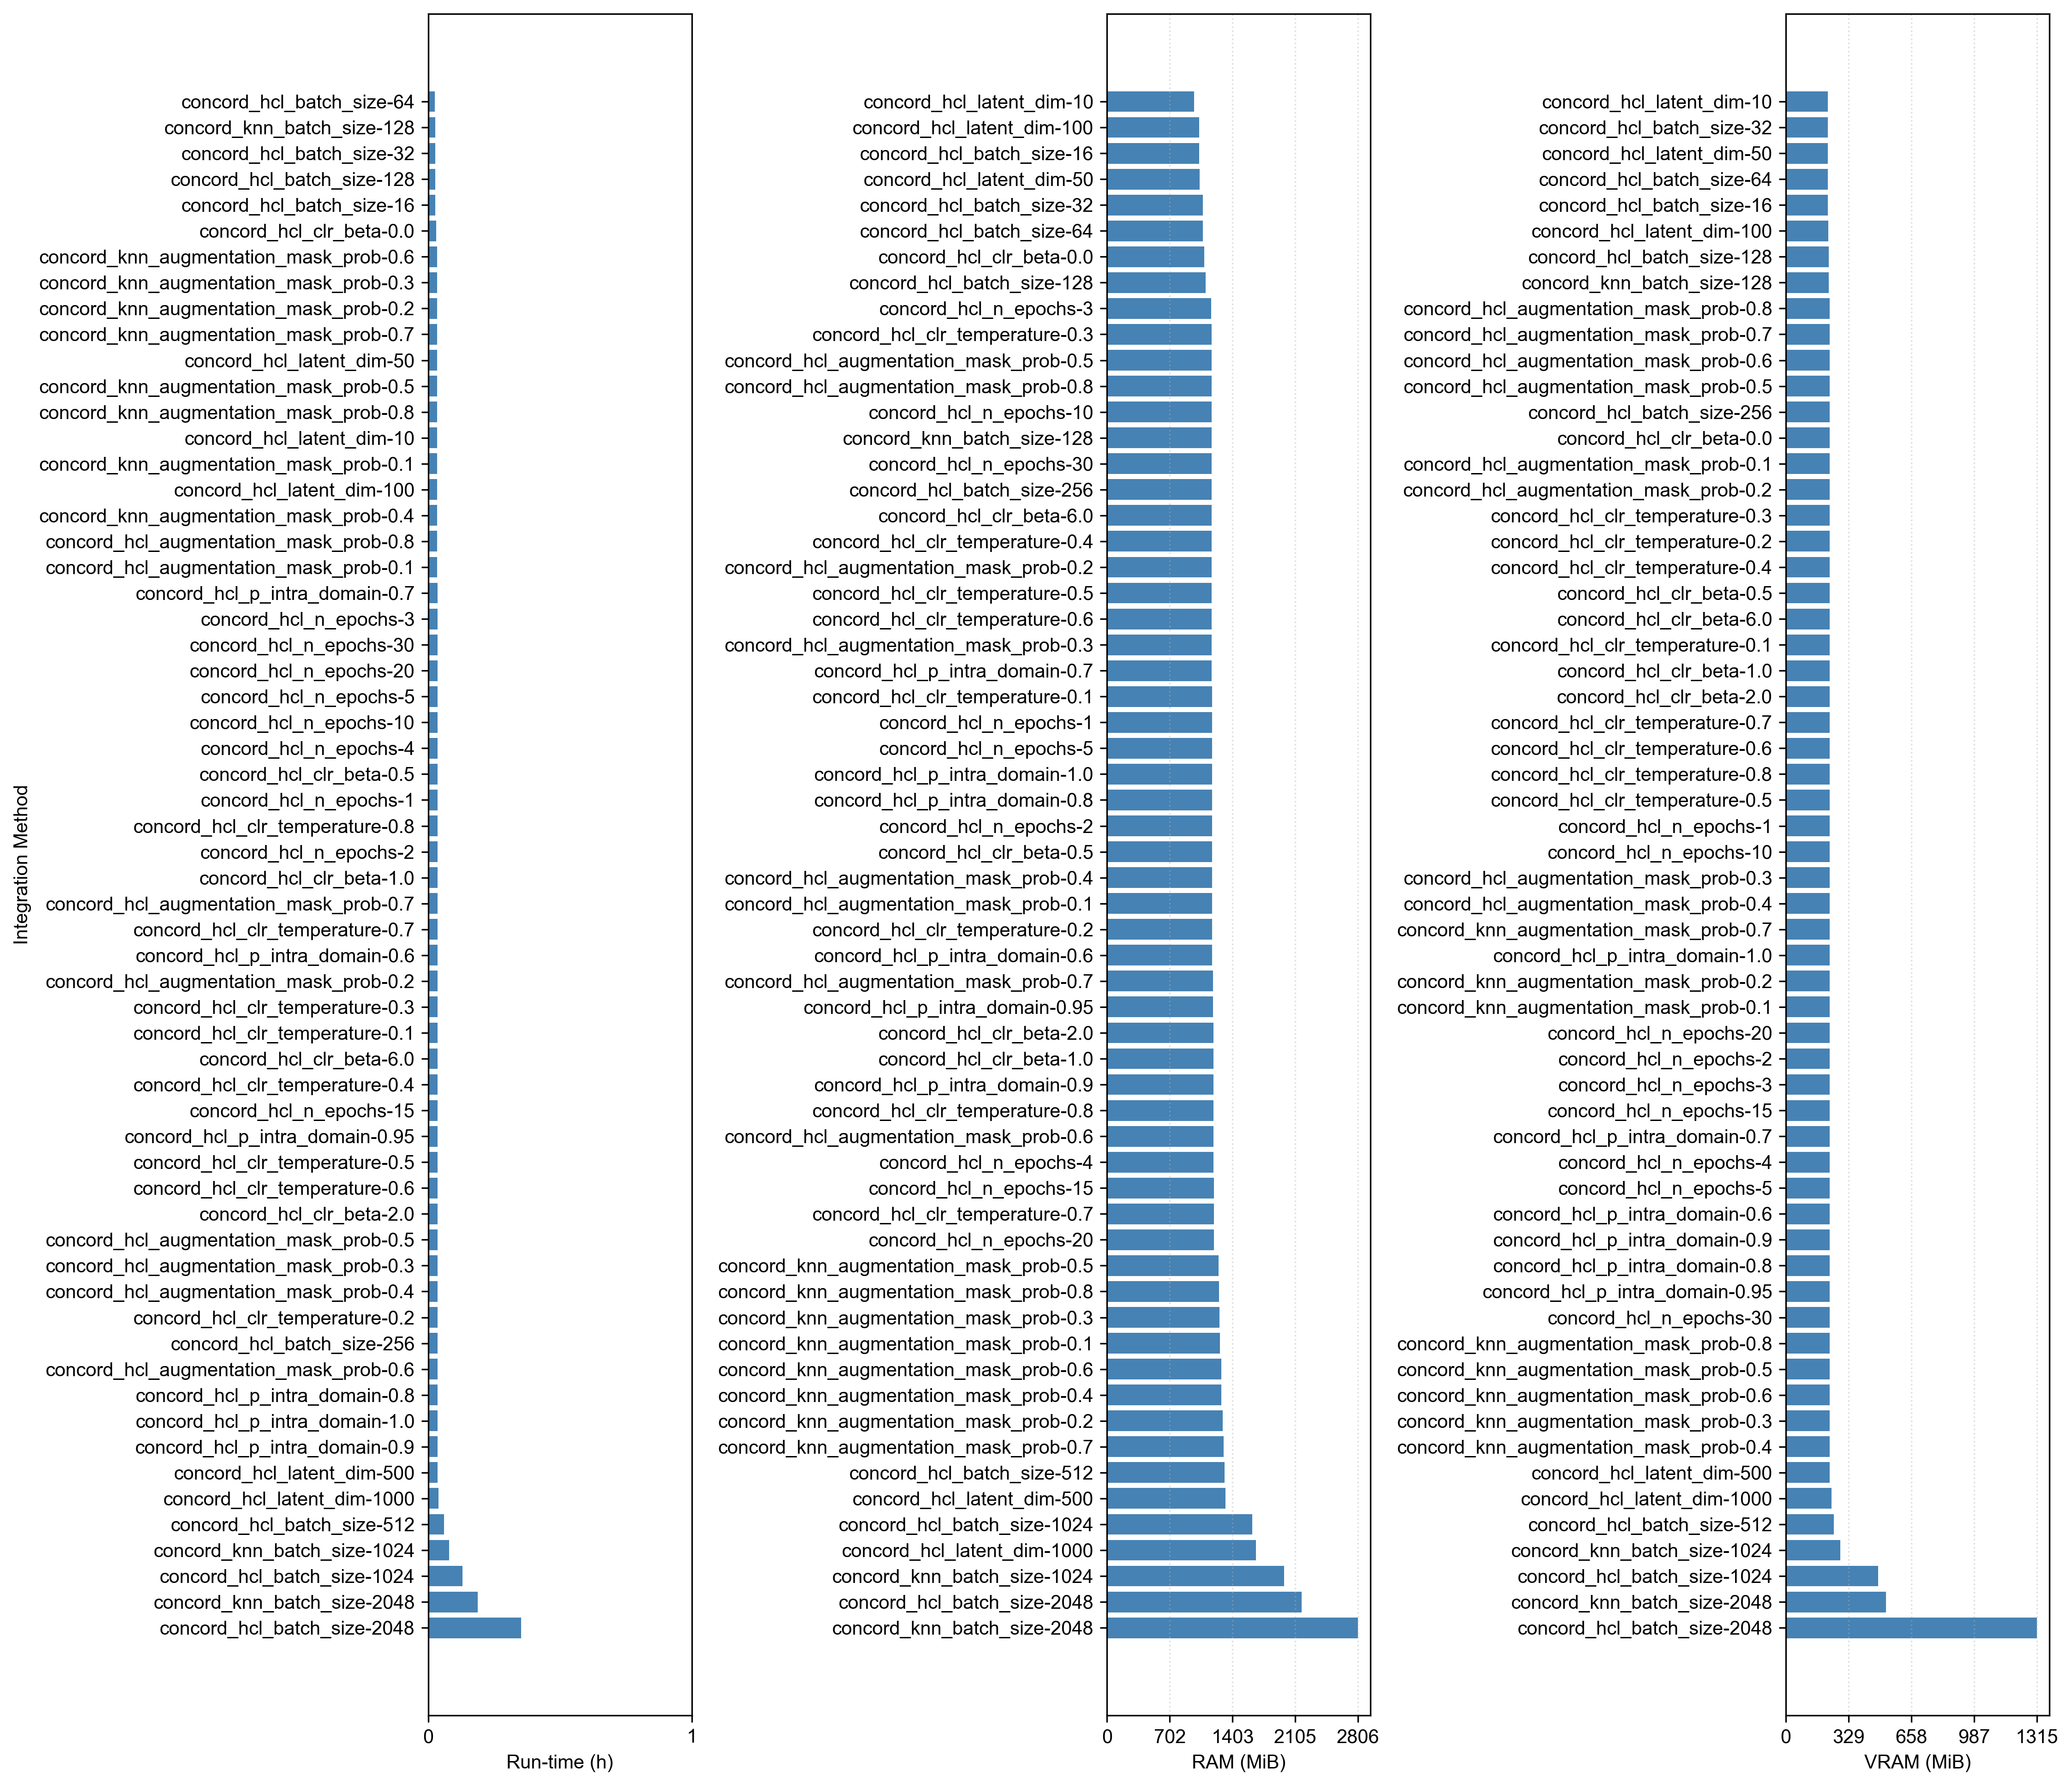

In [15]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(15,13), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


#### Benchmark cell type

In [16]:
import numpy as np
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']
bad_cells = adata.obs['cell_type'].isin(bad_annotation) 
adata_ct = adata[~bad_cells].copy()
print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_ct.shape}")

✅ Filtered adata to remove bad annotations, new shape: (43686, 10000)


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentation_mask_prob-0.8', 'concord_hcl_batch_size-128', 'concord_hcl_batch_size-256', 'concord_hcl_batch_size-64']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentati

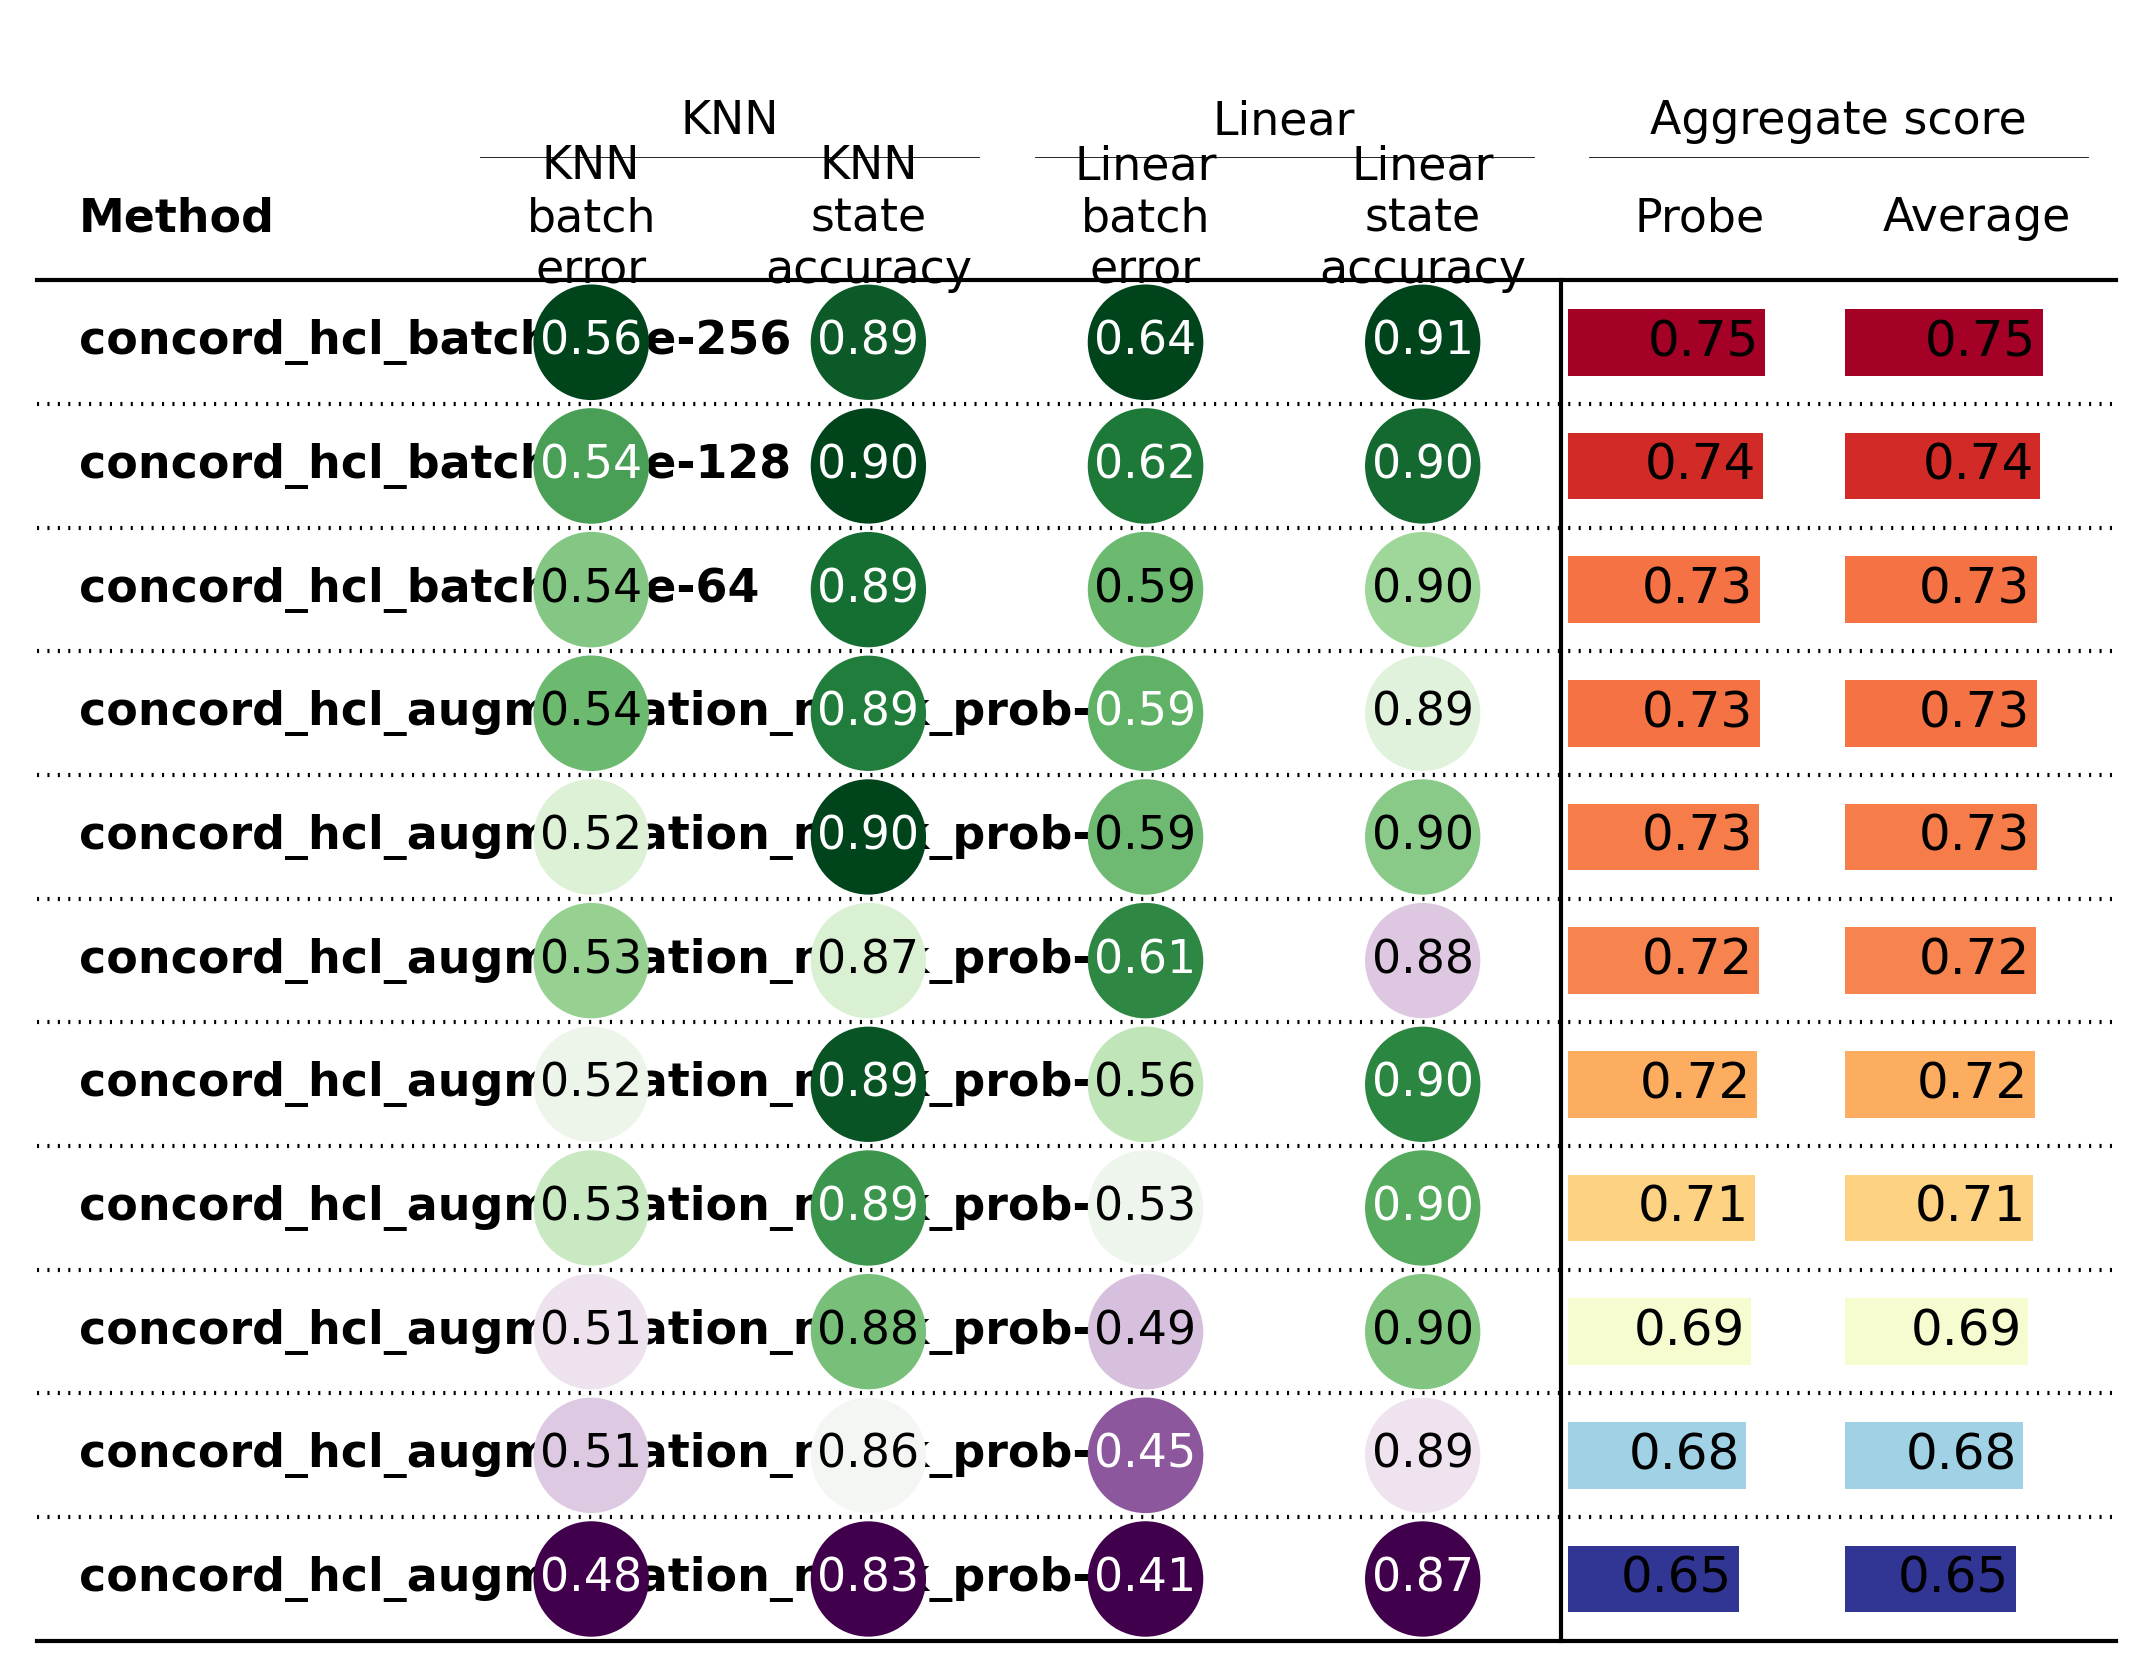

✅ Benchmark results saved to: ../save/cel_packerN2_hyperv2/benchmark_cell_type_Jul03-2226.pkl


In [49]:
state_key = 'cell_type'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata_ct,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")

In [50]:
combined_celltype.to_csv(save_dir / f"combined_celltype_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined cell type results saved to: {save_dir / f'combined_celltype_{file_suffix}.tsv'}")

✅ Combined cell type results saved to: ../save/cel_packerN2_hyperv2/combined_celltype_Jul03-2226.tsv


In [53]:
combined_celltype

KNN                  \
                                       batch\nerror state\naccuracy   
Method                                                                
concord_hcl_batch_size-256                 0.555047        0.892424   
concord_hcl_batch_size-128                 0.541772        0.895171   
concord_hcl_batch_size-64                  0.535821        0.889906   
concord_hcl_augmentation_mask_prob-0.2     0.538224        0.888304   
concord_hcl_augmentation_mask_prob-0.3     0.523919        0.895171   
concord_hcl_augmentation_mask_prob-0.1     0.533875        0.870336   
concord_hcl_augmentation_mask_prob-0.4     0.519684        0.892996   
concord_hcl_augmentation_mask_prob-0.5     0.527237        0.885672   
concord_hcl_augmentation_mask_prob-0.6     0.512589        0.880179   
concord_hcl_augmentation_mask_prob-0.7     0.507897        0.864958   
concord_hcl_augmentation_mask_prob-0.8     0.479515        0.833028   

                                             Linear                  \
                                       batch\nerror state\naccuracy   
Method                                                                
concord_hcl_batch_size-256                 0.640838        0.906032   
concord_hcl_batch_size-128                 0.616573        0.903514   
concord_hcl_batch_size-64                  0.588188        0.895960   
concord_hcl_augmentation_mask_prob-0.2     0.591851        0.891267   
concord_hcl_augmentation_mask_prob-0.3     0.587044        0.896875   
concord_hcl_augmentation_mask_prob-0.1     0.610507        0.884285   
concord_hcl_augmentation_mask_prob-0.4     0.558773        0.901568   
concord_hcl_augmentation_mask_prob-0.5     0.530617        0.899279   
concord_hcl_augmentation_mask_prob-0.6     0.489642        0.897333   
concord_hcl_augmentation_mask_prob-0.7     0.445004        0.886689   
concord_hcl_augmentation_mask_prob-0.8     0.406089        0.871352   

                                       Aggregate score            
                                                 Probe   Average  
Method                                                            
concord_hcl_batch_size-256                    0.748585  0.748585  
concord_hcl_batch_size-128                    0.739257  0.739257  
concord_hcl_batch_size-64                     0.727469  0.727469  
concord_hcl_augmentation_mask_prob-0.2        0.727411  0.727411  
concord_hcl_augmentation_mask_prob-0.3        0.725752  0.725752  
concord_hcl_augmentation_mask_prob-0.1        0.724751  0.724751  
concord_hcl_augmentation_mask_prob-0.4        0.718255  0.718255  
concord_hcl_augmentation_mask_prob-0.5        0.710701  0.710701  
concord_hcl_augmentation_mask_prob-0.6        0.694936  0.694936  
concord_hcl_augmentation_mask_prob-0.7        0.676137  0.676137  
concord_hcl_augmentation_mask_prob-0.8        0.647496  0.647496

#### Benchmark lineage

In [51]:
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']
bad_cells = adata.obs['lineage_complete'].isin(bad_annotation) 
adata_lineage = adata[~bad_cells].copy()
print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_lineage.shape}")

✅ Filtered adata to remove bad annotations, new shape: (35636, 10000)


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentation_mask_prob-0.8', 'concord_hcl_batch_size-128', 'concord_hcl_batch_size-256', 'concord_hcl_batch_size-64']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentati

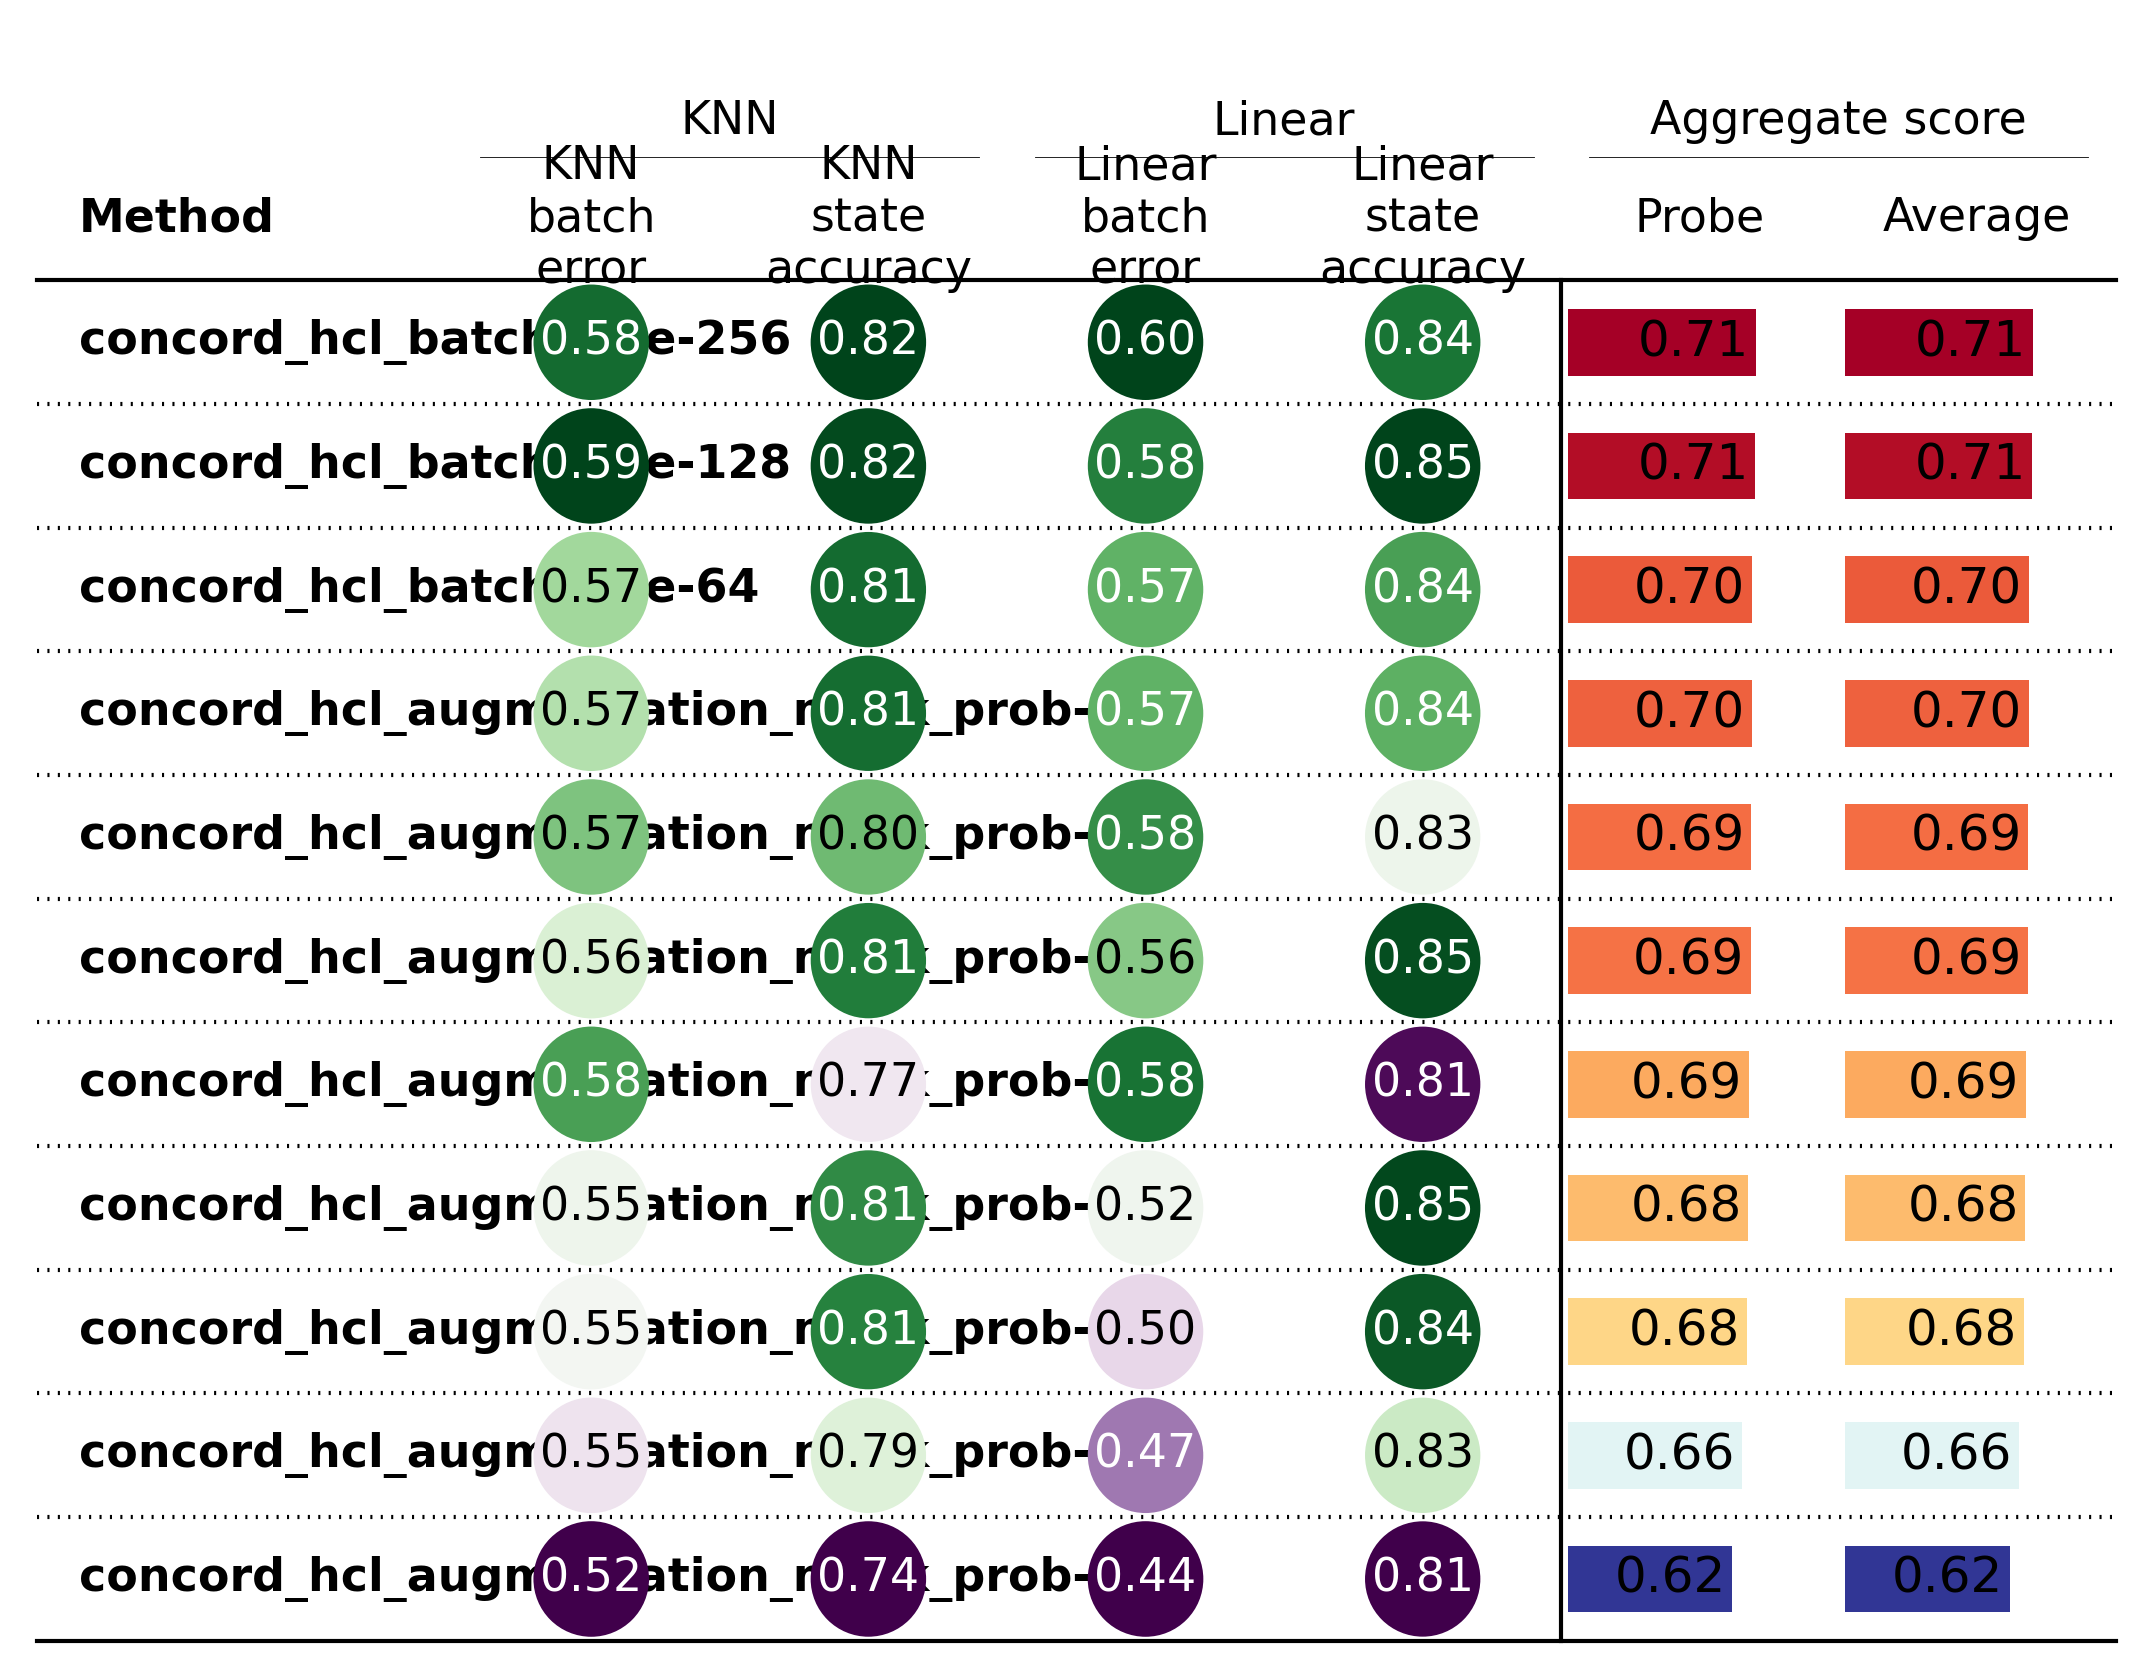

✅ Benchmark results saved to: ../save/cel_packerN2_hyperv2/benchmark_lineage_complete_Jul03-2226.pkl


In [52]:
state_key = 'lineage_complete'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata_lineage,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_lineage",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_lineage = out["combined"]
combined_lineage

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")


In [27]:
combined_lineage.to_csv(save_dir / f"combined_lineage_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined lineage results saved to: {save_dir / f'combined_lineage_{file_suffix}.tsv'}")

✅ Combined lineage results saved to: ../save/cel_packerN2_hyperv2/combined_lineage_Jul03-2226.tsv


### Visualize the results

In [31]:
SAVE_ROOT

PosixPath('../save/cel_packerN2_hyperv2')

In [19]:
import re
from pathlib import Path
import itertools

import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 0  CONFIG ─ paths, metric, cosmetics
# ───────────────────────────────────────────────────────────────
SAVE_ROOT   = save_dir
FILE_SUFFIX = file_suffix

CELL_TSV   = SAVE_ROOT / f"combined_celltype_{FILE_SUFFIX}.tsv"
LINE_TSV   = SAVE_ROOT / f"combined_lineage_{FILE_SUFFIX}.tsv"

BASE_CELL  = Path("../save/cel_packerN2_hyperparam/") / f"other_celltype_Jul03-1254.tsv"
BASE_LINE  = Path("../save/cel_packerN2_hyperparam/") / f"other_lineage_Jul03-1254.tsv"

METRIC_COL = "Aggregate score.1"          # ← use any column you like

COLORS     = {"Cell type": "#1f77b4",     # consistent colour palette
              "Lineage":   "#ff7f0e"}

# dash patterns for up to 8 baselines – extend / customise as needed
DASHES = ["solid", "dashed", "dotted", "dashdot",
          (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (1, 1)), (0, (5, 1, 1, 1))]
# ───────────────────────────────────────────────────────────────
# 1  Helpers
# ───────────────────────────────────────────────────────────────
score_cols = ["KNN", "KNN.1", "Linear", "Linear.1",
              "Aggregate score", "Aggregate score.1"]

_method_re = re.compile(r"concord_(hcl|knn)_(.+?)-(.+)$")

def parse_method(name: str):
    """concord_<mode>_<param>-<val>  →  (mode, param, value)."""
    m = _method_re.match(name)
    if m is None:
        return None, None, None
    mode, param, val = m.groups()
    try:
        val = float(val) if "." in val else int(val)
    except ValueError:
        pass
    return mode, param, val


def load_hyperparam_table(path: Path, target_label: str) -> pd.DataFrame:
    """Read hyper-parameter sweep table and return tidy frame."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df[["mode", "param", "value"]] = df["Unnamed: 0"].apply(
        lambda s: pd.Series(parse_method(s))
    )
    df["acc"]   = df[METRIC_COL]
    df["target"] = target_label
    return df.dropna(subset=["mode", "param"])


def load_baseline_table(path: Path, target_label: str) -> pd.DataFrame:
    """Baseline tables have one row per method (no hyper-params)."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df["method"]  = df["Unnamed: 0"].str.strip()
    df["acc"]     = df[METRIC_COL]
    df["target"]  = target_label
    return (df[["method", "acc", "target"]]
              .dropna(subset=["method"]))

# ───────────────────────────────────────────────────────────────
# 2  Load and fuse data
# ───────────────────────────────────────────────────────────────
hp_cell  = load_hyperparam_table(CELL_TSV,  "Cell type")
hp_line  = load_hyperparam_table(LINE_TSV,  "Lineage")

hyper_df = pd.concat([hp_cell, hp_line], ignore_index=True)

baseline_cell = load_baseline_table(BASE_CELL, "Cell type")
baseline_line = load_baseline_table(BASE_LINE, "Lineage")
baseline_df   = pd.concat([baseline_cell, baseline_line], ignore_index=True)

# mean across repeats (if any)
hp_summary = (hyper_df
              .groupby(["mode", "param", "value", "target"], as_index=False)["acc"]
              .mean())

base_summary = (baseline_df
                .groupby(["method", "target"], as_index=False)["acc"]
                .mean())

# assign dash-patterns to each method
style_map = {m: d for m, d in zip(base_summary["method"].unique(),
                                  itertools.cycle(DASHES))}


FileNotFoundError: [Errno 2] No such file or directory: '../save/cel_packerN2_hyperv2/combined_celltype_Jul04-0012.tsv'

In [34]:
base_summary

,method,target,acc
0,concord_hcl,Cell type,0.724321
1,concord_hcl,Lineage,0.701789
2,concord_knn,Cell type,0.707698
3,concord_knn,Lineage,0.678780
4,contrastive,Cell type,0.513190
5,contrastive,Lineage,0.456647
6,harmony,Cell type,0.732735
7,harmony,Lineage,0.696214
8,liger,Cell type,0.544085
9,liger,Lineage,0.441205


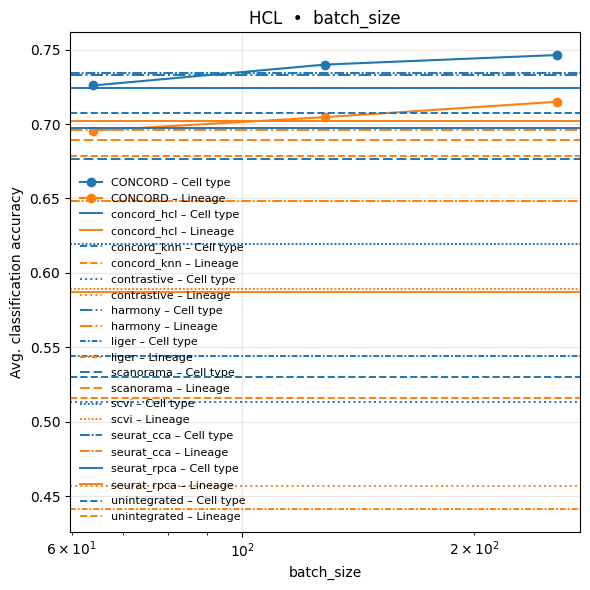

In [35]:

# ───────────────────────────────────────────────────────────────
# 3  Plot
# ───────────────────────────────────────────────────────────────
for (mode, param), sub in hp_summary.groupby(["mode", "param"]):
    sub = sub.sort_values("value")

    fig, ax = plt.subplots(figsize=(6, 6))

    # 3-A  CONCORD sweep (solid line per target)
    for tgt, grp in sub.groupby("target"):
        ax.plot(grp["value"], grp["acc"],
                marker="o", linestyle="solid",
                color=COLORS[tgt], label=f"CONCORD – {tgt}")

    # 3-B  Other methods – horizontal lines
    for _, row in base_summary.iterrows():
        tgt     = row["target"]
        method  = row["method"]
        style   = style_map[method]

        ax.axhline(row["acc"],
                   color=COLORS[tgt],
                   linestyle=style,
                   linewidth=1.4,
                   label=f"{method} – {tgt}")

    # cosmetics
    ax.set_title(f"{mode.upper()}  •  {param}")
    ax.set_xlabel(param)
    ax.set_ylabel("Avg. classification accuracy")

    if param in {"batch_size", "latent_dim", "sampler_knn"}:
        ax.set_xscale("log")

    ax.grid(alpha=0.3, zorder=0)
    # deduplicate legend entries (one per line)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), frameon=False, fontsize=8)

    fig.tight_layout()
    plt.show()


In [56]:
### Load other methods
import pickle
res_other_cell_type = pickle.load(open("../save/cel_packerN2/benchmark_probe_cell_type_Jun29-1317.pkl", "rb"))
res_other_cell_type = res_other_cell_type["combined"]
res_other_cell_type
res_other_cell_type.to_csv(save_dir / f"other_celltype_{file_suffix}.tsv", sep="\t", index=True)

res_other_lineage = pickle.load(open("../save/cel_packerN2/benchmark_probe_lineage_complete_Jun29-1317.pkl", "rb"))
res_other_lineage = res_other_lineage["combined"]
res_other_lineage
res_other_lineage.to_csv(save_dir / f"other_lineage_{file_suffix}.tsv", sep="\t", index=True)

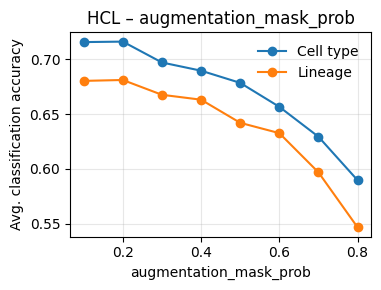

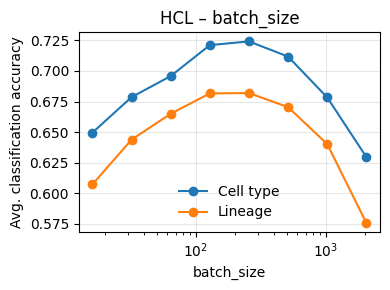

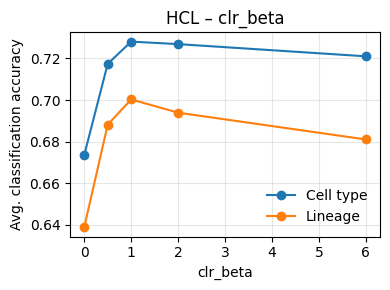

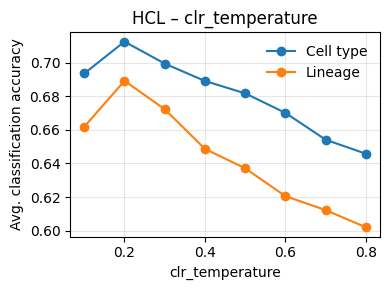

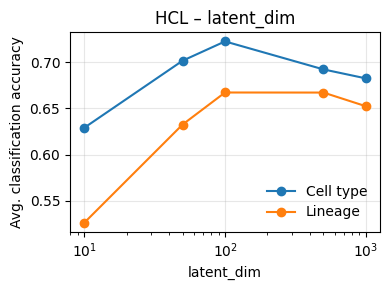

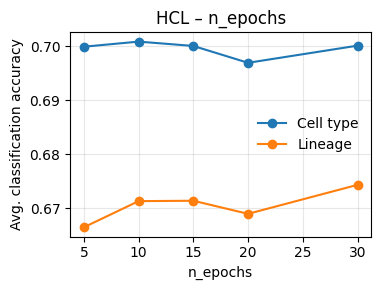

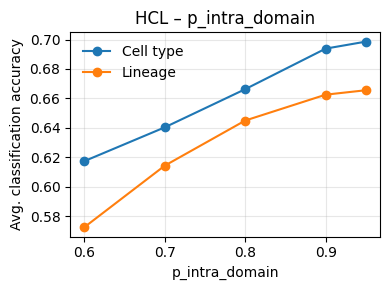

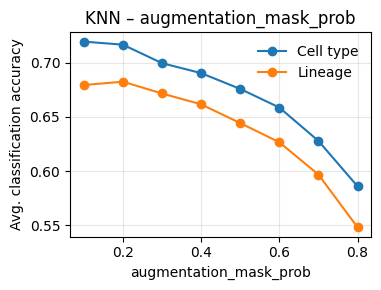

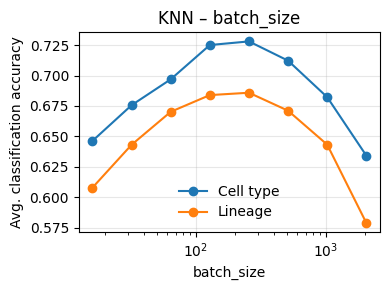

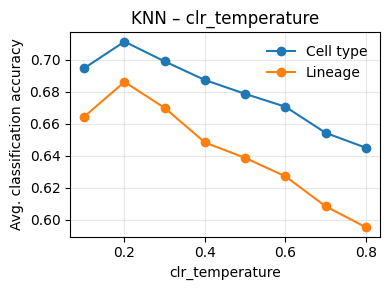

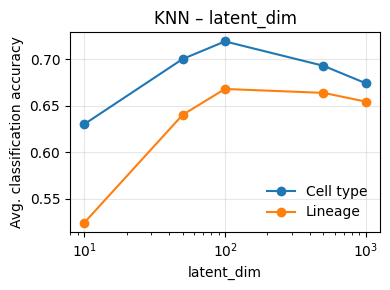

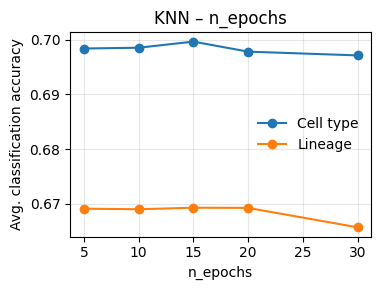

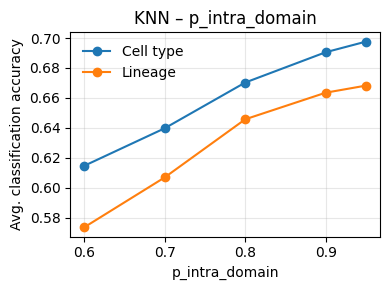

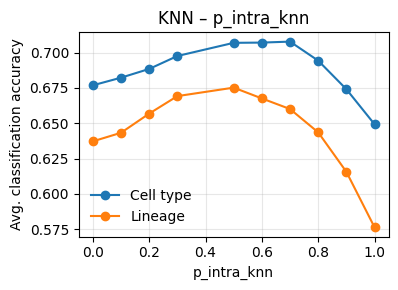

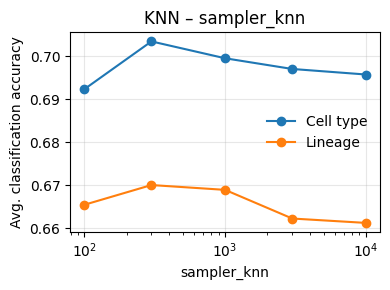

In [ ]:


# ───────────────────────────────────────────────────────────────
# 3.  Plot:  one panel per (mode, param) with two lines
# ───────────────────────────────────────────────────────────────
for (mode, param), sub in summary.groupby(["mode", "param"]):
    sub = sub.sort_values("value")

    fig, ax = plt.subplots(figsize=(4, 3))
    for tgt, grp in sub.groupby("target"):
        ax.plot(grp["value"], grp["acc"], marker="o", label=tgt)

    ax.set_title(f"{mode.upper()} – {param}")
    ax.set_xlabel(param)
    ax.set_ylabel("Avg. classification accuracy")

    if param in {"batch_size", "latent_dim", "sampler_knn"}:
        ax.set_xscale("log")

    ax.grid(alpha=0.3)
    ax.legend(frameon=False)
    fig.tight_layout()
    plt.show()